# Arctic Sea ice files 

* **Description**: Creates file of Utqiagvik data from MESACLIP - both nearest point and average of nearby grid points
* **Input data**: MESACLIP daily timeseries data
* **Output data**: Netcdf with data
* **Creator**: Alice DuVivier
* **Date**: December 2025

### Import Packages

In [1]:
#import utils
import xarray as xr
import numpy as np
from glob import glob
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean

import dask
from dask.distributed import Client
from dask_jobqueue import PBSCluster
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='1:00:00', cores=1, processes=1, memory='8 GB',interface='ext')

# Spin up 18 workers
cluster.scale(18)

# Assign the cluster to our Client
client = Client(cluster)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35869 instead
  f"Port {expected} is already in use.\n"


In [3]:
client
# cluster.close()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/35869/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/35869/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:42335,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/35869/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Find point nearest Utqiagvik

In [4]:
# set latitude and longitude of Village (longitudes must be in 0-360)
name_village = 'Utqiagvik'
lat_village = 71.29
lon_village = 203.21
#longitue = -156.79

### ATM grid file

In [5]:
# set a dataset to read in to get grid information
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/mesaclip_all_arctic/daily/UBOT/'
file_in = 'MESACLIP_HIST_002_1920_UBOT_alaska_daily.nc'
ds_grid = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [6]:
# grab lat and lon data
lat1d = ds_grid.lat
lon1d = ds_grid.lon
temp = ds_grid.UBOT.isel(time=0)

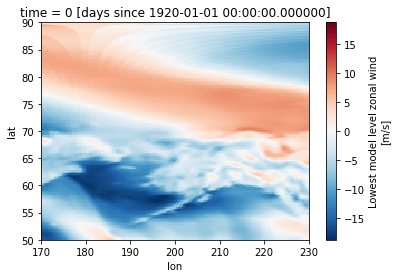

In [7]:
temp.plot()

In [8]:
# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat1d - lat_village)
abslon = np.abs(lon1d - lon_village)

# find the smallest values
xloc = np.where(abslat == np.min(abslat))
yloc = np.where(abslon == np.min(abslon))

# print index values
print(xloc[0],yloc[0])

[85] [132]


In [9]:
# Check how close these are to the latitude and longitude of the village
print(name_village+': '+str(lat_village)+','+str(lon_village))

lat_grid = lat1d.isel(lat=xloc[0]).values
lon_grid = lon1d.isel(lon=yloc[0]).values
print('grid point: '+str(lat_grid)+','+str(lon_grid))

Utqiagvik: 71.29,203.21
grid point: [71.375],[203.125]


In [10]:
#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon1d,lat1d)

# convert the numpy array to an xarray
lon2d = xr.DataArray(lon2d,dims=('lat','lon'))
lat2d = xr.DataArray(lat2d,dims=('lat','lon'))

# assign coordinates
lon2d['lat'] = ds_grid.lat
lon2d['lon'] = ds_grid.lon
lat2d['lat'] = ds_grid.lat
lat2d['lon'] = ds_grid.lon

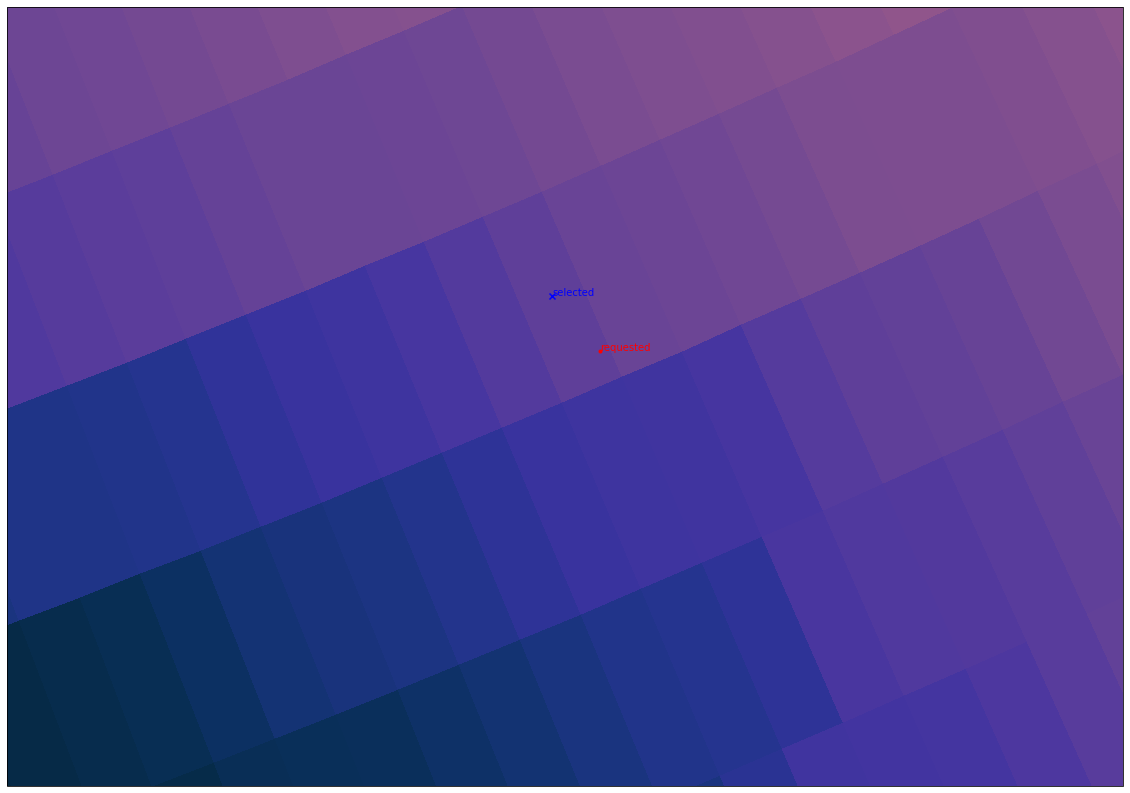

In [11]:
# Plot the Grid points to ensure we have the closest point for plots
fig = plt.figure(figsize=(20,20))

# make plot
ax = plt.subplot(1,1,1)
ax = plt.subplot(1,1,1,projection = ccrs.NorthPolarStereo(central_longitude=180.0) )
#ax.set_extent([-140, -179, 72, 69], crs=ccrs.PlateCarree())
ax.set_extent([-155, -159, 71.5, 71], crs=ccrs.PlateCarree())

# do a pcolormesh plot of input
cs0 = ax.pcolormesh(lon2d, lat2d, temp,
                    cmap = cmocean.cm.thermal, vmin = 0, vmax = 10,
                    transform=ccrs.PlateCarree())

# do scatter plot of all grid values
#cs1 = ax.plot(lon2d, lat2d,temp,
#              c='white',marker='.', linestyle='none',
#              transform=ccrs.PlateCarree())

# Plot requested lat/lon point
cs2 = ax.scatter(lon_village, lat_village, marker='.',c='red', transform=ccrs.PlateCarree())
tx1 = ax.text(lon_village, lat_village, 'requested', c='red', transform=ccrs.PlateCarree())

# Plot nearest point in the array red
cs4 = plt.scatter(lon2d.isel(lat=xloc[0],lon=yloc[0]), lat2d.isel(lat=xloc[0],lon=yloc[0]), marker='x', color='blue', transform=ccrs.PlateCarree())
tx2 = plt.text(lon2d.isel(lat=xloc[0],lon=yloc[0]), lat2d.isel(lat=xloc[0],lon=yloc[0]), 'selected', c='blue', transform=ccrs.PlateCarree())
               

- This point is an ocean point and nearest UTQ. Proceed!

In [12]:
# print original index values
#print(xloc[0],yloc[0])
xloc = int(xloc[0])
yloc = int(yloc[0])

print(xloc,yloc)

85 132


- Also find the nearest ocean points to UTQ that are similar in scale to CESM 1deg scale to average over

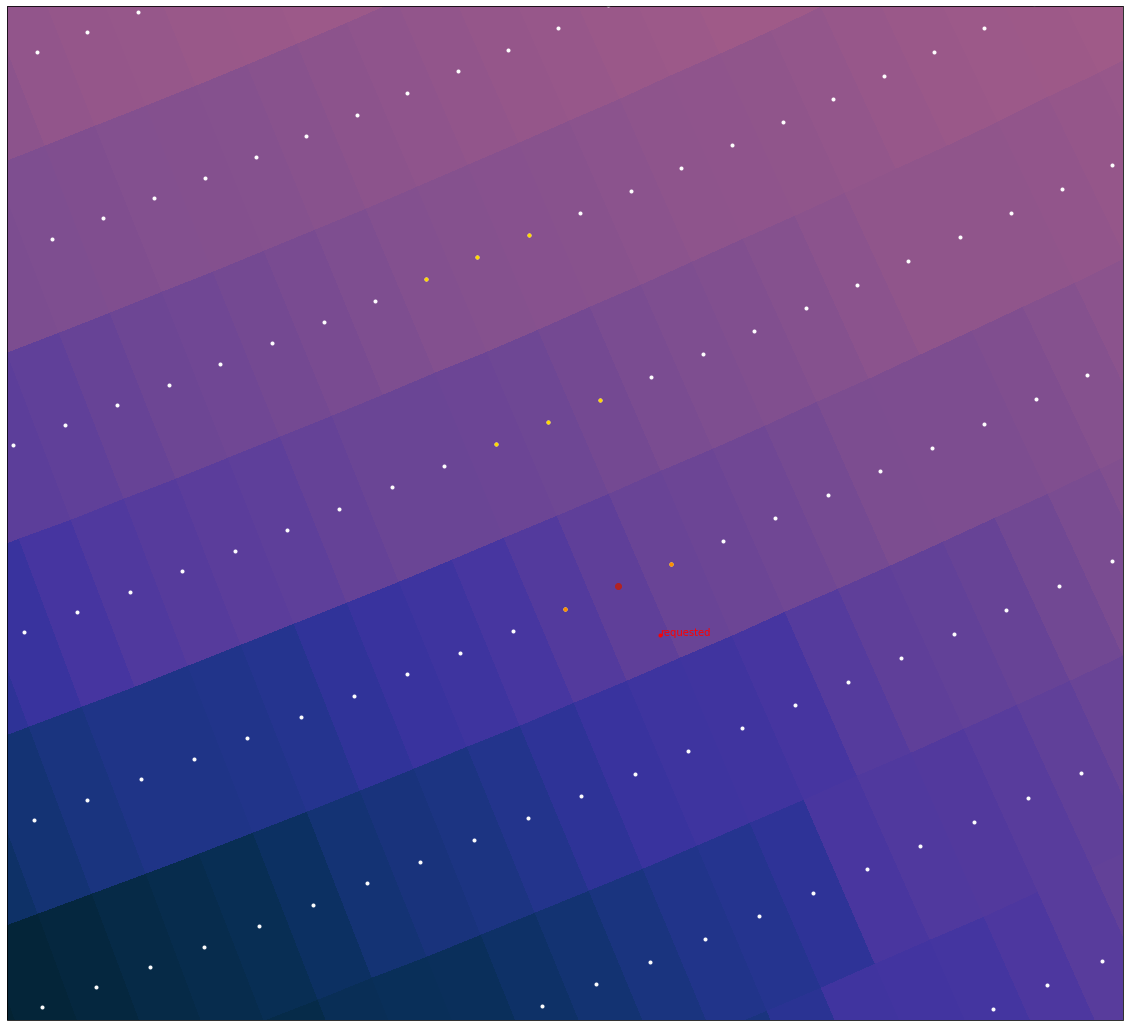

In [13]:
# Plot the Grid points to ensure we have the closest point for plots
fig = plt.figure(figsize=(20,20))

# make plot
ax = plt.subplot(1,1,1)
ax = plt.subplot(1,1,1,projection = ccrs.NorthPolarStereo(central_longitude=180.0) )
ax.set_extent([-155, -159, 72, 71], crs=ccrs.PlateCarree())

# do a pcolormesh plot of input
cs0 = ax.pcolormesh(lon2d, lat2d, temp,
                    cmap = cmocean.cm.thermal, vmin = 0, vmax = 10,
                    transform=ccrs.PlateCarree())

# do scatter plot of all grid values
cs1 = ax.plot(lon2d, lat2d,temp,
              c='white',marker='.', linestyle='none',
              transform=ccrs.PlateCarree())

# Plot requested lat/lon point
cs2 = ax.scatter(lon_village, lat_village, marker='.',c='red', transform=ccrs.PlateCarree())
tx1 = ax.text(lon_village, lat_village, 'requested', c='red', transform=ccrs.PlateCarree())

# Plot nearest point in the array red
xind_st = xloc
xind_ed = xloc+3
yind_st = yloc-1
yind_ed = yloc+2
ax.scatter(lon2d.isel(lat=slice(xind_st,xind_ed),lon=slice(yind_st,yind_ed)), lat2d.isel(lat=slice(xind_st,xind_ed),lon=slice(yind_st,yind_ed)), marker=".", color='gold',zorder=100,transform=ccrs.PlateCarree())
yind_st = yloc-1
yind_ed = yloc+2
ax.scatter(lon2d.isel(lat=xloc,lon=slice(yind_st,yind_ed)), lat2d.isel(lat=xloc,lon=slice(yind_st,yind_ed)), marker=".", color='darkorange',zorder=100,transform=ccrs.PlateCarree())
ax.scatter(lon2d.isel(lat=xloc,lon=yloc), lat2d.isel(lat=xloc,lon=yloc), marker="o",color='firebrick',zorder=100,transform=ccrs.PlateCarree())
   

In [14]:
# print averaging index values for 3x3 box
print('Indices for 3x3 box averaging')
print(xloc,xloc+3)
print(yloc-1,yloc+2)

Indices for 3x3 box averaging
85 88
131 134


In [15]:
# print averaging index values for 3x1 box
print('Indices for 3x1 box averaging')
print(xloc)
print(yloc-1,yloc+2)

Indices for 3x1 box averaging
85
131 134


## Read in MESACLIP ensemble members - Historical AND two RCP options

In [20]:
# Select variable of interest and locate the files
# varname options = 'U10'

varname = 'U10'
path = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/mesaclip_all_arctic/daily/' + varname

In [21]:
# list ensemble names
ens_mems = ['001','002', '003', '004', '005', '006', '007', '008', '009', '010']
nens = len(ens_mems)

print(nens)

10


In [22]:
def read_data(files, varname, chunks):
    ds = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, 
                           concat_dim="time", combine='nested', decode_times=True, chunks=chunks)
    # keep only some variables
    keep_vars=['lat','lon','time'] + [varname]
    return ds.drop([v for v in ds.variables if v not in keep_vars])


### Load historical data
- Missing 1st ensemble member data

In [23]:
print('loading historical data')
ds_hist = xr.Dataset()
native_chunks={'time': 1, 'ni': 600, 'nj': 550} # ncdump -s <file> shows "aice_d:_ChunkSizes = 1, 550, 600"
better_chunks={'time': 3650, 'ni': 100, 'nj': 110} # 150 MB chunks?

for m in ens_mems: 
    print(m)
    case = 'MESACLIP_HIST_' + m
    files = sorted(glob(f'{path}/{case}_????-????_{varname}_alaska_daily.nc'))       
    ds_hist = xr.concat([ds_hist,read_data(files, varname, better_chunks)], dim='member_id')

loading historical data
001
002


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


003
004
005
006
007
008
009
010


In [24]:
# keep just the variable of interest
ds_hist = ds_hist[varname]

# eliminate any duplicate times (atm files include the last timestep from previous year otherwise)
ds_hist = ds_hist.drop_duplicates(dim='time')

In [25]:
# keep only box around the point we're interested in (near village); will pull out village cell AND average over box
ds_hist_village_box = ds_hist.isel(lat=slice(xloc,xloc+3),lon=slice(yloc-1,yloc+2))
ds_hist_village_box

,Array,Chunk
Bytes,21.55 MiB,256.64 kiB
Shape,"(10, 31391, 3, 3)","(1, 3650, 3, 3)"
Count,1845 Tasks,170 Chunks
Type,float64,numpy.ndarray


### Load future data - RCP6.0
- Original data was missing year 2051 for ens 007, so we've just duplicated that file and read it in twice.

In [26]:
%%time

print('loading RCP6.0 data')
ds_60 = xr.Dataset()
native_chunks={'time': 1, 'ni': 600, 'nj': 550} # ncdump -s <file> shows "aice_d:_ChunkSizes = 1, 550, 600"
better_chunks={'time': 3650, 'ni': 100, 'nj': 110} # 150 MB chunks?

# data available for all members
for m in ens_mems:
    print(m)
    case = 'MESACLIP_RCP6.0_' + m
    files = sorted(glob(f'{path}/{case}_????-????_{varname}_alaska_daily.nc'))       
    ds_60 = xr.concat([ds_60,read_data(files, varname, better_chunks)], dim='member_id')

loading RCP6.0 data
001
002


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


003


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


004
005
006
007
008


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


009


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


010
CPU times: user 3.09 s, sys: 70.3 ms, total: 3.16 s
Wall time: 6.98 s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [27]:
# keep just the variable of interest
ds_60 = ds_60[varname]

# eliminate any duplicate times (atm files include the last timestep from previous year otherwise)
ds_60 = ds_60.drop_duplicates(dim='time')

In [28]:
# keep only box around the point we're interested in (near village); will pull out village cell AND average over box
ds_60_village_box = ds_60.isel(lat=slice(xloc,xloc+3),lon=slice(yloc-1,yloc+2))
ds_60_village_box

,Array,Chunk
Bytes,23.81 MiB,256.64 kiB
Shape,"(10, 34676, 3, 3)","(1, 3650, 3, 3)"
Count,1338 Tasks,110 Chunks
Type,float64,numpy.ndarray


### Load future data - RCP8.5

In [35]:
%%time

print('loading RCP8.5 data')
ds_85 = xr.Dataset()
native_chunks={'time': 1, 'ni': 600, 'nj': 550} # ncdump -s <file> shows "aice_d:_ChunkSizes = 1, 550, 600"
better_chunks={'time': 3650, 'ni': 100, 'nj': 110} # 150 MB chunks?

# intentionally not loading first few members - no data available
for m in ens_mems[3:8]:
    print(m)
    case = 'MESACLIP_RCP8.5_' + m
    files = sorted(glob(f'{path}/{case}_????-????_{varname}_alaska_daily.nc'))       
    ds_85 = xr.concat([ds_85,read_data(files, varname, better_chunks)], dim='member_id')

loading RCP8.5 data
004
005
006
007
008
CPU times: user 1.1 s, sys: 19.1 ms, total: 1.12 s
Wall time: 2.17 s


In [36]:
# keep just the variable of interest
ds_85 = ds_85[varname]

# eliminate any duplicate times (atm files include the last timestep from previous year otherwise)
ds_85 = ds_85.drop_duplicates(dim='time')

In [37]:
# keep only box around the point we're interested in (near village); will pull out village cell AND average over box
ds_85_village_box = ds_85.isel(lat=slice(xloc,xloc+3),lon=slice(yloc-1,yloc+2))
ds_85_village_box

<xarray.DataArray 'U10' (member_id: 5, time: 34676, lat: 3, lon: 3)>
dask.array<getitem, shape=(5, 34676, 3, 3), dtype=float64, chunksize=(1, 3650, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2100-12-31 12:00:00
  * lat      (lat) float64 71.38 71.62 71.88
  * lon      (lon) float64 202.9 203.1 203.4
Dimensions without coordinates: member_id
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: maximum

## Actually load data

In [38]:
def compute_box_average_and_village_value(ds):
    print(f"Village is at {ds.isel(member_id=0,lat=0,lon=1)['lon'].values:.2f} E, {ds.isel(member_id=0,lat=0,lon=1)['lat'].values:.2f} N")
    ds_compute = ds.compute()
    one_pt = ds_compute.isel(lat=0,lon=1)
    small_box = ds_compute.isel(lat=0).mean(dim=["lon"])
    big_box = ds_compute.mean(dim=["lat", "lon"])
    return one_pt, small_box, big_box

In [39]:
%%time
ds_hist_pt, ds_hist_small_box,ds_hist_big_box = compute_box_average_and_village_value(ds_hist_village_box)
ds_hist_village_box

Village is at 203.12 E, 71.38 N
CPU times: user 885 ms, sys: 171 ms, total: 1.06 s
Wall time: 15.4 s


,Array,Chunk
Bytes,21.55 MiB,256.64 kiB
Shape,"(10, 31391, 3, 3)","(1, 3650, 3, 3)"
Count,1845 Tasks,170 Chunks
Type,float64,numpy.ndarray


In [40]:
%%time
ds_60_pt, ds_60_small_box,ds_60_big_box = compute_box_average_and_village_value(ds_60_village_box)
ds_60_village_box

Village is at 203.12 E, 71.38 N
CPU times: user 2.31 s, sys: 441 ms, total: 2.75 s
Wall time: 44.8 s


,Array,Chunk
Bytes,23.81 MiB,256.64 kiB
Shape,"(10, 34676, 3, 3)","(1, 3650, 3, 3)"
Count,1338 Tasks,110 Chunks
Type,float64,numpy.ndarray


In [41]:
%%time
ds_85_pt, ds_85_small_box,ds_85_big_box = compute_box_average_and_village_value(ds_85_village_box)
ds_85_village_box

Village is at 203.12 E, 71.38 N
CPU times: user 294 ms, sys: 67 ms, total: 361 ms
Wall time: 3.62 s


<xarray.DataArray 'U10' (member_id: 5, time: 34676, lat: 3, lon: 3)>
dask.array<getitem, shape=(5, 34676, 3, 3), dtype=float64, chunksize=(1, 3650, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2100-12-31 12:00:00
  * lat      (lat) float64 71.38 71.62 71.88
  * lon      (lon) float64 202.9 203.1 203.4
Dimensions without coordinates: member_id
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: maximum

In [42]:
print('Done loading data!')

Done loading data!


## Save the variable
- Netcdf with variable dimension: (member_id x time)
- One netcdf per variable

In [43]:
varname

'U10'

In [44]:
path_out = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/mesaclip_utqiagvik/'

### Historical File

In [45]:
ds_out = xr.Dataset()

ds_out['data_pt'] = ds_hist_pt
ds_out['data_small_box'] = ds_hist_small_box
ds_out['data_big_box'] = ds_hist_big_box

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Daily MESACLIP data for ocean point nearest Utqiagvik'

ds_out

<xarray.Dataset>
Dimensions:         (time: 31391, member_id: 10)
Coordinates:
  * time            (time) object 1920-01-01 00:00:00 ... 2005-12-31 12:00:00
    lat             float64 71.38
    lon             float64 203.1
Dimensions without coordinates: member_id
Data variables:
    data_pt         (member_id, time) float64 nan 3.434 2.207 ... 8.663 6.689
    data_small_box  (member_id, time) float64 nan 3.424 2.288 ... 8.747 6.796
    data_big_box    (member_id, time) float64 nan 3.586 2.477 ... 8.685 6.459
Attributes:
    author:          Alice DuVivier
    date_processed:  2026-01-21
    contents:        Daily MESACLIP data for ocean point nearest Utqiagvik

In [46]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	time: (31391,)
	member_id: (10,)
Coordinates:
	time:
		[cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1920, 1, 1, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1920, 1, 2, 12, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2005, 12, 29, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2005, 12, 30, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2005, 12, 31, 12, 0, 0, 0, has_year_zero=True)]
	lat:
		71.375
	lon:
		203.125
Attributes:
	author: Alice DuVivier
	date_processed: 2026-01-21
	contents: Daily MESACLIP data for ocean point nearest Utqiagvik


In [47]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**2)
print(f"The dataset is approximately {size_gb:.2f} MB.")

The dataset is approximately 7.42 MB.


In [48]:
file_out = name_village+'_MESACLIP_HIST_daily-'+varname+'.nc'
fout = path_out + file_out
print(fout)

/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/mesaclip_utqiagvik/Utqiagvik_MESACLIP_HIST_daily-U10.nc


In [49]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

### RCP6.0

In [50]:
ds_out = xr.Dataset()

ds_out['data_pt'] = ds_60_pt
ds_out['data_small_box'] = ds_60_small_box
ds_out['data_big_box'] = ds_60_big_box

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Monthly MESACLIP data for ocean point nearest Utqiagvik'

ds_out

<xarray.Dataset>
Dimensions:         (time: 34676, member_id: 10)
Coordinates:
  * time            (time) object 2006-01-01 00:00:00 ... 2100-12-31 12:00:00
    lat             float64 71.38
    lon             float64 203.1
Dimensions without coordinates: member_id
Data variables:
    data_pt         (member_id, time) float64 3.708 9.344 7.027 ... 9.697 nan
    data_small_box  (member_id, time) float64 3.734 9.464 7.123 ... 9.848 nan
    data_big_box    (member_id, time) float64 4.847 10.08 7.47 ... 10.72 nan
Attributes:
    author:          Alice DuVivier
    date_processed:  2026-01-21
    contents:        Monthly MESACLIP data for ocean point nearest Utqiagvik

In [51]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	time: (34676,)
	member_id: (10,)
Coordinates:
	time:
		[cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2006, 1, 1, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2006, 1, 2, 12, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 31, 12, 0, 0, 0, has_year_zero=True)]
	lat:
		71.375
	lon:
		203.125
Attributes:
	author: Alice DuVivier
	date_processed: 2026-01-21
	contents: Monthly MESACLIP data for ocean point nearest Utqiagvik


In [52]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**2)
print(f"The dataset is approximately {size_gb:.2f} MB.")

The dataset is approximately 8.20 MB.


In [53]:
file_out = name_village+'_MESACLIP_RCP6.0_daily-'+varname+'.nc'
fout = path_out + file_out
print(fout)

/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/mesaclip_utqiagvik/Utqiagvik_MESACLIP_RCP6.0_daily-U10.nc


In [54]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

### RCP8.5

In [55]:
ds_out = xr.Dataset()

ds_out['data_pt'] = ds_85_pt
ds_out['data_small_box'] = ds_85_small_box
ds_out['data_big_box'] = ds_85_big_box

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Monthly MESACLIP data for ocean point nearest Utqiagvik'

ds_out

<xarray.Dataset>
Dimensions:         (time: 34676, member_id: 5)
Coordinates:
  * time            (time) object 2006-01-01 00:00:00 ... 2100-12-31 12:00:00
    lat             float64 71.38
    lon             float64 203.1
Dimensions without coordinates: member_id
Data variables:
    data_pt         (member_id, time) float64 6.245 9.344 9.753 ... 9.36 6.511
    data_small_box  (member_id, time) float64 6.253 9.267 9.759 ... 9.497 6.654
    data_big_box    (member_id, time) float64 7.155 9.275 9.689 ... 10.38 7.684
Attributes:
    author:          Alice DuVivier
    date_processed:  2026-01-21
    contents:        Monthly MESACLIP data for ocean point nearest Utqiagvik

In [56]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	time: (34676,)
	member_id: (5,)
Coordinates:
	time:
		[cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2006, 1, 1, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2006, 1, 2, 12, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2100, 12, 31, 12, 0, 0, 0, has_year_zero=True)]
	lat:
		71.375
	lon:
		203.125
Attributes:
	author: Alice DuVivier
	date_processed: 2026-01-21
	contents: Monthly MESACLIP data for ocean point nearest Utqiagvik


In [57]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**2)
print(f"The dataset is approximately {size_gb:.2f} MB.")

The dataset is approximately 4.23 MB.


In [58]:
file_out = name_village+'_MESACLIP_RCP8.5_daily-'+varname+'.nc'
fout = path_out + file_out
print(fout)

/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/mesaclip_utqiagvik/Utqiagvik_MESACLIP_RCP8.5_daily-U10.nc


In [59]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

### Done!

In [60]:
print('Done loading data!')
client.shutdown()

Done loading data!


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
